# Regression Discontinuity Design

* Tecnica aplicada quando temos um tratamento que é atribuido a partir de um corte (certo valor) de uma variavel, se for antes do corte a observacao é nao tratada, se for depois, é uma tratada
* Comparar o resultado logo acima e logo abaixo do limiar de descontinuidade para identificar o efeito do tratamento no local
* A probabilidade do tratamento salta de 0 a 1, ou de forma menos radical, na passagem do limiar
* Supomos que as observações que cairam próximas ao limiar, seja antes ou depois, são muito semelhantes, a diferença que, aleatoriamente, estão de lados opostos (tratados e não tratados)
* Elementos do modelo:
    * Variável de execucao: Característica que determina se a observacao é uma tratada ou não
    * Outcome: Variável que será influenciada pelo tratamento, em que será refletido o efeito
    * Corte: Limite do valor da variavel de execucacao que determina se a observacao é tratada ou não
    * Tratamento: Variável que se deseja mensurar o efeito/impacto
    * Variaveis de confusão: Variáveis que causam (estão correlacionadas) tanto o outcome quanto o tratamento
        * Variavel de redução da variabilidade: Característica que auxilia na redução da variabilidade da variavel resposta (outcome)
        * Essenciais em o aumento do tratamento não é de 0 a 1, ha outros fatores que influenciam no outcome
* Cuidado se algo muda na observacao na passagem do corte, além da variável execucao e variaveis de confusao
    * Se nao fosse o tratamento, o patamar do outcome deveria ser semelhante

In [1]:
import pandas as pd
import numpy as np
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import matplotlib.ticker as mtick
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

# Tema: Óbitos em virtude do alcool dos 25 aos 29 anos

* Segundo matéria jornalista abaixo, a idade média do primeiro emprego do brasileiro era aos 25 anos entre 2006 e 2014 e, recentemente, essa média subiu para os 28 anos
    * https://economia.ig.com.br/2019-05-12/brasileiro-tem-primeiro-emprego-com-carteira-assinada-em-media-apos-os-28-anos.html
* Em conjunto com este fato, dados do OIT apontam que 50% dos afastamentos/ausências do trabalho são em virtude do alcoolismo
    * https://www.em.com.br/app/noticia/economia/2015/01/21/internas_economia,609960/alcoolismo-mina-a-produtividade.shtml
* Desta forma, investiga-se se, na passagem dos 25 aos 28 anos, faixa média do primeiro emprego, ha um salto no volume de óbitos em consequência do uso do alcool, relacionado a introdução no mundo do trabalho
    * Além da idade, acrescenta-se a variável de gênero, dado que, historicamente, homens possuem expectativa de vida menor do que mulheres no Brasil
* Dados do datasus: http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sim/cnv/obt10uf.def
    * Dados de 2016 a 2019, óbitos p/ residência

In [2]:
obitos = pd.read_csv('rdd_obitos_alcool.csv',encoding='latin-1', sep = ";")
obitos = obitos.rename(columns={'ï»¿genero': 'genero'})

* Dados da base
    * Genero: É uma variavel empregada para redução da variabilidade
    * Idade: Variavel de tratamento
    * Percentual de obitos em virtude de alcool: Variavel outcome
        * Contempla os seguintes categorias de obitos:
            * Transtornos mentais comportamentais devido ao uso alcool
            * Doenc alcoolica do figado
            * Envenenamento acidental p/e exposicao ao alcool
            * Auto-intoxicação voluntaria p/alcool

* Grafico de causalidade

In [3]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
import hyper
from causalgraphicalmodels import CausalGraphicalModel
import graphviz

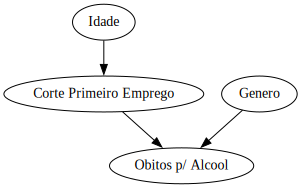

In [4]:
sprinkler = CausalGraphicalModel(
    nodes=['Genero','Idade','Corte Primeiro Emprego','Obitos p/ Alcool'],
    edges=[
        ("Idade", "Corte Primeiro Emprego"),
        ("Corte Primeiro Emprego", "Obitos p/ Alcool"),
        ("Genero", "Obitos p/ Alcool")
    ]
)

sprinkler.draw()

In [5]:
obitos.head()

,genero,idade,perc_obito_alcool
0,homem,Menor 1 ano,0.0000
1,homem,1 a 4 anos,0.0000
2,homem,5 a 9 anos,0.0000
3,homem,10 a 14 anos,0.0001
4,homem,15 a 19 anos,0.0007


* Primeira analise dos dados
    * Observa-se que, inicialmente, os óbitos relacionados ao alcool estão próximos a zero nas primeiras faixas de idade
    * Posteriormente, tanto para mulheres, mas principalmente para homens, o % das mortes se eleva, com grandes saltos dos 25 anos em diante, conforme queremos mensurar

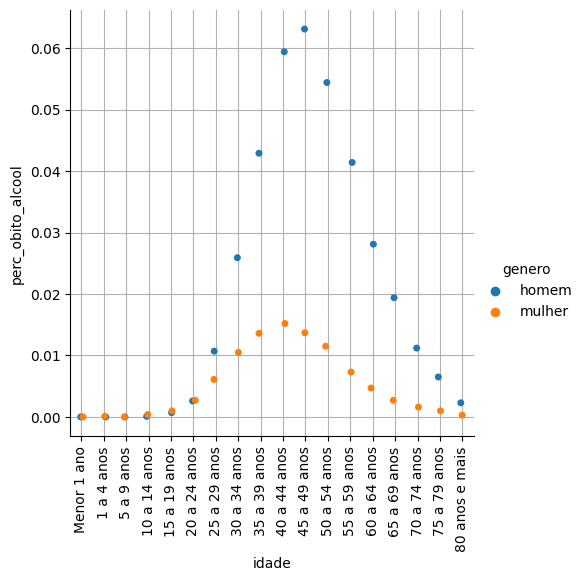

In [6]:
import seaborn as sns
sns.catplot(data=obitos, x="idade", y="perc_obito_alcool", hue="genero")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [7]:
# Centralizando o corte em zero, e os demais periodos colocados em ordem
idade = {
    'Menor 1 ano': -6,
    '1 a 4 anos' : -5,
    '5 a 9 anos' : -4,
    '10 a 14 anos' : -3,
    '15 a 19 anos' : -2,
    '20 a 24 anos' : -1,
'25 a 29 anos' : 0,
'30 a 34 anos' : 1,
'35 a 39 anos' : 2,
'40 a 44 anos' : 3,
'45 a 49 anos' : 4,
'50 a 54 anos' : 5,
'55 a 59 anos' : 6,
'60 a 64 anos' : 7,
'65 a 69 anos' : 8,
'70 a 74 anos' : 9,
'75 a 79 anos' : 10,
'80 anos e mais': 11
}

In [8]:
obitos['idade_cont'] = obitos['idade'].map(idade)

In [9]:
# Transformando a variavel genero em dummy
obitos2 = pd.get_dummies(obitos,columns=['genero'], drop_first = False)

In [10]:
obitos2.drop(['idade'],axis=1,inplace=True)

In [11]:
obitos2.head()

,perc_obito_alcool,idade_cont,genero_homem,genero_mulher
0,0.0000,-6,1,0
1,0.0000,-5,1,0
2,0.0000,-4,1,0
3,0.0001,-3,1,0
4,0.0007,-2,1,0


In [12]:
# Criando a variavel de corte, em que, se a idade for a partir da categoria dos 29 anos, assumirá valor 1
rdd_obitos = obitos2.assign(threshold=(obitos["idade_cont"] > 0).astype(int))

In [13]:
rdd_obitos.head()

,perc_obito_alcool,idade_cont,genero_homem,genero_mulher,threshold
0,0.0000,-6,1,0,0
1,0.0000,-5,1,0,0
2,0.0000,-4,1,0,0
3,0.0001,-3,1,0,0
4,0.0007,-2,1,0,0


In [14]:
# Criando variaveis de interacao
rdd_obitos['idade_thres'] = rdd_obitos['idade_cont'] * rdd_obitos['threshold'] #interacao entre idade e o corte
rdd_obitos['homem_thres'] = rdd_obitos['genero_homem'] * rdd_obitos['threshold'] #interacao entre genero masculino e corte

In [15]:
X = rdd_obitos[['idade_cont','genero_homem','threshold','idade_thres','homem_thres']] #separando variaveis explicativas
X = sm.add_constant(X)
Y = rdd_obitos[['perc_obito_alcool']]

In [16]:
model = sm.OLS(Y,X).fit()

* Primeiro modelo
    * O R2 é de 0.75, assim, o modelo em questão explica boa parte da variabilidade
    * Todavia, há variaveis não significativas, sendo assim, o modelo precisará ser ajustado

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      perc_obito_alcool   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     18.11
Date:                Fri, 05 May 2023   Prob (F-statistic):           2.87e-08
Time:                        23:15:46   Log-Likelihood:                 119.27
No. Observations:                  36   AIC:                            -226.5
Df Residuals:                      30   BIC:                            -217.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0048      0.005      0.906      0.372      -0.006       0.016
idade_cont       0.0011      0.001      0.865      0.394      -0.002       0.004
genero_homem     0.0005      0.005      0.105      0.917      -0.010       0.011
threshold        0.0215      0.007      2.988      0.006       0.007       0.036
idade_thres     -0.0043      0.001     -2.953      0.006      -0.007      -0.001
homem_thres      0.0242      0.007      3.672      0.001       0.011       0.038
==============================================================================
Omnibus:                        4.716   Durbin-Watson:                   0.888
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                3.941
Skew:                           0.366   Prob(JB):                        0.139
Kurtosis:                       4.446   Cond. No.                         47.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Segundo modelo exclui a variável de genero masculino, com maior p-valor
    * Novamente, ainda há p-valor não significativos

In [18]:
X = rdd_obitos[['idade_cont','threshold','idade_thres','homem_thres']]
X = sm.add_constant(X)
Y = rdd_obitos[['perc_obito_alcool']]
model2 = sm.OLS(Y,X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      perc_obito_alcool   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     23.38
Date:                Fri, 05 May 2023   Prob (F-statistic):           5.51e-09
Time:                        23:15:47   Log-Likelihood:                 119.26
No. Observations:                  36   AIC:                            -228.5
Df Residuals:                      31   BIC:                            -220.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0051      0.005      1.113      0.274      -0.004       0.014
idade_cont      0.0011      0.001      0.880      0.386      -0.001       0.004
threshold       0.0213      0.007      3.211      0.003       0.008       0.035
idade_thres    -0.0043      0.001     -3.001      0.005      -0.007      -0.001
homem_thres     0.0248      0.004      6.118      0.000       0.017       0.033
==============================================================================
Omnibus:                        4.714   Durbin-Watson:                   0.888
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                3.934
Skew:                           0.367   Prob(JB):                        0.140
Kurtosis:                       4.444   Cond. No.                         37.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Terceiro modelo, na sequência, retira a variável de idade 

In [19]:
X = rdd_obitos[['threshold','idade_thres','homem_thres']]
X = sm.add_constant(X)
Y = rdd_obitos[['perc_obito_alcool']]
model3 = sm.OLS(Y,X).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      perc_obito_alcool   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     31.14
Date:                Fri, 05 May 2023   Prob (F-statistic):           1.30e-09
Time:                        23:15:48   Log-Likelihood:                 118.82
No. Observations:                  36   AIC:                            -229.6
Df Residuals:                      32   BIC:                            -223.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0017      0.003      0.689      0.496      -0.003       0.007
threshold       0.0246      0.005      4.557      0.000       0.014       0.036
idade_thres    -0.0031      0.001     -4.937      0.000      -0.004      -0.002
homem_thres     0.0248      0.004      6.140      0.000       0.017       0.033
==============================================================================
Omnibus:                        4.263   Durbin-Watson:                   0.946
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                3.218
Skew:                           0.377   Prob(JB):                        0.200
Kurtosis:                       4.256   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Por fim, o último modelo nao acrescenta a constante

In [20]:
X = rdd_obitos[['threshold','idade_thres','homem_thres']]
Y = rdd_obitos[['perc_obito_alcool']]
model4 = sm.OLS(Y,X).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      perc_obito_alcool   R-squared (uncentered):                   0.830
Model:                            OLS   Adj. R-squared (uncentered):              0.815
Method:                 Least Squares   F-statistic:                              53.83
Date:                Fri, 05 May 2023   Prob (F-statistic):                    8.36e-13
Time:                        23:15:49   Log-Likelihood:                          118.55
No. Observations:                  36   AIC:                                     -231.1
Df Residuals:                      33   BIC:                                     -226.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
threshold       0.0264      0.005      5.567      0.000       0.017       0.036
idade_thres    -0.0031      0.001     -4.977      0.000      -0.004      -0.002
homem_thres     0.0248      0.004      6.190      0.000       0.017       0.033
==============================================================================
Omnibus:                        3.066   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.216   Jarque-Bera (JB):                2.081
Skew:                           0.173   Prob(JB):                        0.353
Kurtosis:                       4.126   Cond. No.                         18.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Analise dos Resultados
* Observa-se que a partir do corte da idade estudado, o % de obitos relacionados ao alcool aumenta cerca de 2.6%.
* Ao passo que, se este ainda for homem, há um acréscimo de 2.4% no share das mortes deste gênero
* Por fim, posteriormente ao crescimento deste tipo de óbito próximo ao corte, o share dos óbitos tende a cair conforme as idades mais avançadas, 0.031% a cada faixa etária a partir dos 30 anos

# Teste Placebo
* Para verificarmos se o efeito é significativo, podemos testar o modelo de descontinuidade com uma variável que não deveria ser afetada pelo tratamento, ou seja, que deveria seguir a mesma tendência antes e depois do corte
* No caso de causa dos óbitos, há diversas causas que são características de determinadas idades, sendo assim, deve-se escolher com cautela a variável para ser empregada como placebo
    * No caso analisado, utiliza-se a causa de óbito relacionados a acidentes com correntes elétricas que, após as idades da infância, entende-se que deve ser estável ao longo da fase da adolescência e adulta, sendo assim, não deveria variar bruscamente antes e depois do corte

In [21]:
obitos_aciden = pd.read_csv('rdd_obitos_acidentes.csv',encoding='latin-1', sep = ";")
obitos_aciden = obitos_aciden.rename(columns={'ï»¿genero': 'genero'})

In [22]:
obitos_aciden.head()

,genero,idade,perc_obito_acid
0,homem,Menor 1 ano,0.0004
1,homem,1 a 4 anos,0.0079
2,homem,5 a 9 anos,0.0095
3,homem,10 a 14 anos,0.0134
4,homem,15 a 19 anos,0.0051


* Pelo grafico abaixo, identifica-se, ao menos inicialmente, que não há grandes saltos nas idades próximas de 25 a 29 anos

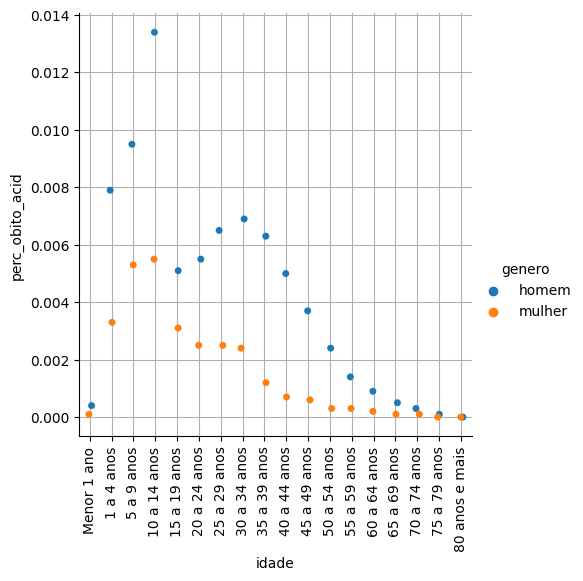

In [23]:
import seaborn as sns
sns.catplot(data=obitos_aciden, x="idade", y="perc_obito_acid", hue="genero")
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [24]:
idade = {
    'Menor 1 ano': -6,
    '1 a 4 anos' : -5,
    '5 a 9 anos' : -4,
    '10 a 14 anos' : -3,
    '15 a 19 anos' : -2,
    '20 a 24 anos' : -1,
'25 a 29 anos' : 0,
'30 a 34 anos' : 1,
'35 a 39 anos' : 2,
'40 a 44 anos' : 3,
'45 a 49 anos' : 4,
'50 a 54 anos' : 5,
'55 a 59 anos' : 6,
'60 a 64 anos' : 7,
'65 a 69 anos' : 8,
'70 a 74 anos' : 9,
'75 a 79 anos' : 10,
'80 anos e mais': 11
}
obitos_aciden['idade_cont'] = obitos_aciden['idade'].map(idade)
obitos2_aciden = pd.get_dummies(obitos_aciden,columns=['genero'], drop_first = False)
obitos2_aciden.drop(['idade'],axis=1,inplace=True)
rdd_obitos_aciden = obitos2_aciden.assign(threshold=(obitos_aciden["idade_cont"] > 0).astype(int))

In [25]:
rdd_obitos_aciden['idade_thres'] = rdd_obitos_aciden['idade_cont'] * rdd_obitos_aciden['threshold'] 
rdd_obitos_aciden['homem_thres'] = rdd_obitos_aciden['genero_homem'] * rdd_obitos_aciden['threshold'] 

In [26]:
X = rdd_obitos_aciden[['idade_cont','genero_homem','threshold','idade_thres','homem_thres']] #separando variaveis explicativas
X = sm.add_constant(X)
Y = rdd_obitos_aciden[['perc_obito_acid']]

* O modelo abaixo revela que as variáveis marcadas com o corte (threshold) não são significativas, ou seja, sem saltos próximos ao corte

In [27]:
model5 = sm.OLS(Y,X).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        perc_obito_acid   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     9.639
Date:                Fri, 05 May 2023   Prob (F-statistic):           1.45e-05
Time:                        23:02:15   Log-Likelihood:                 173.15
No. Observations:                  36   AIC:                            -334.3
Df Residuals:                      30   BIC:                            -324.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0039      0.001      3.239      0.003       0.001       0.006
idade_cont       0.0002      0.000      0.773      0.445      -0.000       0.001
genero_homem     0.0037      0.001      3.216      0.003       0.001       0.006
threshold       -0.0006      0.002     -0.350      0.729      -0.004       0.003
idade_thres     -0.0007      0.000     -2.110      0.043      -0.001   -2.19e-05
homem_thres     -0.0018      0.001     -1.185      0.245      -0.005       0.001
==============================================================================
Omnibus:                        8.558   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               13.303
Skew:                           0.402   Prob(JB):                      0.00129
Kurtosis:                       5.868   Cond. No.                         47.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""